========================================================================================================================
# National University of Singapore
# Pattern Recognition (EE5907)
## Assignment CA1
## Matriculation: A0179741U
## Name: Rogatiya Mohmad Aspak Arif
========================================================================================================================

**First thing First**
1. Import necessary python packages
1. Load spamData.mat file
2. Read features and labels for training and test data. 
2. Log transform the feature data for training and test sets. (For Q2, Q3 and Q4)
3. Binarize the feature data for traing and test sets. (For Q1)
6. Flatten the label data in 1D array.

In [1]:
# 1. import necessary python packages
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import binarize
import scipy.spatial.distance as dist
import math

# 2. Load spamData.mat file
matObject = loadmat('spamData.mat')

# 3. Read feature and labels for training and test data
xTrainOrig = matObject['Xtrain']
yTrainOrig = matObject['ytrain']

xTestOrig = matObject['Xtest']
yTestOrig = matObject['ytest']

# 4. Log transform the feature data for training and test sets
xTrainLog = np.log(xTrainOrig+0.1)
xTestLog = np.log(xTestOrig+0.1)

# 5. Binarize the feature data for training and test
xTrainBin = binarize(xTrainOrig)
xTestBin = binarize(xTestOrig)

# 6. Flatten the label data in 1D array
yTrainFlat = yTrainOrig.flatten()
yTestFlat = yTestOrig.flatten()

=========================================================================================================================
## Q1: Beta-binomial Naive Bayes ##

Fit a **Beta-Binomial naive Bayes classifier** on the **binarized data** from the Data Processing section. Since there are a lot of spam and non-spam emails, you do not need to assume any prior on the class label. In other words, the **class label prior λ can be estimated using ML** and you can use λ^ML as a plug-in estimator for testing.

On the other hand, you should assume a prior **Beta(α,α)** on the feature distribution (note that the two hyperparameters for the Beta prior are set to be the same). For each value of **α = {0, 0.5, 1, 1.5, 2, · · · , 100}**, fit the classifier on the training data and compute its error rate (i.e., percentage of emails classified wrongly) on the test data. For the features (i.e., when computing p(x|y)), please use Bayesian (i.e., posterior predictive) training and testing (see week 3 lecture notes on “Predicting Target Class of Test Data ˜x Using Posterior Predictive Distribution”).

Make sure you include at least the following in your report:

**• Plots of training and test error rates versus α**

**• What do you observe about the training and test errors as α change?**

**• Training and testing error rates for α = 1, 10 and 100.**

=========================================================================================================================

### Function to calculate the Maximum Likelihood (ML) for given label.

In [2]:
# Calculate Maximum Likelihood (ML) for given label
def calculateML(label):
    return np.log(list(yTrainFlat).count(label)/len(yTrainFlat))

### Function to calculate Feature Likelihood (FL)

In [3]:
# Calculate Feature Likelihood (FL)
def calculateFL(index,feature,α,label,FL,labelCount):
    tempCal = ( (FL[index]+α) / (labelCount + (α*2)) )  
    if(feature == 1):
        return np.log(tempCal)
    else:
        return np.log(1 - tempCal)

### Classifier function.

In [4]:
# Classify a given email as spam or non-spam for given alpha    
def classify(email,α):
    probList = []
    for labelIndex,label in enumerate(labels):
        probLabel = lambdaLabels[labelIndex]
        FL = FL_list[labelIndex]
        labelCount = labelCounts[labelIndex]
        for index, feature in enumerate(email):
            probLabel += calculateFL(index,feature,α,label,FL,labelCount)
        probList.append(probLabel)
    return (labels[probList.index(max(probList))])

### Prepare the list of lambdas, label frequencies and feature likelihood for each label.

In [5]:
labels = [0,1]

FL_list = []
lambdaLabels = []
labelCounts = []

for labelIndex,label in enumerate(labels):
    FL_list.append(xTrainBin[yTrainFlat==label].sum(axis=0))
    lambdaLabels.append(calculateML(label))
    labelCounts.append(list(yTrainFlat).count(label))

### List of alphas given in assignment question.

 α = {0, 0.5, 1, 1.5, 2, · · · , 100}

In [6]:
αList = np.arange(0,100.5,0.5)

### Classify each email in training and test data set and compare against real label. Repeat it for each α.

In [7]:
trainError = []
testError = []    
for αIndex, α in enumerate(αList):
    training_results = []
    test_results = []

    for index,email in enumerate(xTrainBin):
        training_results.append(classify(email,α))
    training_results = np.asarray(training_results)
    trainError.append(np.sum(yTrainFlat == training_results))

    for index,email in enumerate(xTestBin):
        test_results.append(classify(email,α))
    test_results = np.asarray(test_results)
    testError.append(np.sum(yTestFlat == test_results))

### Find number of incorrect classifications for training and test set.

In [8]:
totalTrainMails = len(yTrainFlat)
trainError[:] = [(1-x/totalTrainMails)*100 for x in trainError]

totalTestMails = len(yTestFlat)
testError[:] = [(1-x/totalTestMails)*100 for x in testError]

### Plots of training and test error rates versus α

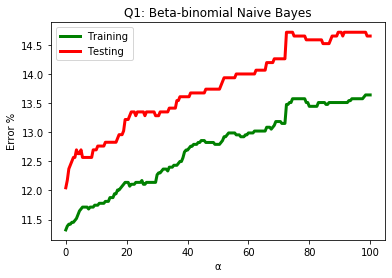

In [9]:
plt.plot(αList,trainError,'g',label='Training', linewidth=3)
plt.plot(αList,testError,'r',label='Testing', linewidth=3)
plt.title('Q1: Beta-binomial Naive Bayes')
plt.ylabel('Error %')
plt.xlabel('α')
plt.legend()
plt.show()

### What do you observe about the training and test errors as α change?

The error rate generally increases as the α increases. However, the error rate for test set is higher compared to training set, because the training data is already used during the training.

### Training and testing error rates for α = 1, 10 and 100.

In [10]:
for α in [1,10,100]:
    print ("α: ",α)
    print ("Training error:\t %.2f" % trainError[αList.tolist().index(α)])
    print ("Test error:\t %.2f" % testError[αList.tolist().index(α)])
    print ("---------------------------")

α:  1
Training error:	 11.42
Test error:	 12.37
---------------------------
α:  10
Training error:	 11.75
Test error:	 12.70
---------------------------
α:  100
Training error:	 13.64
Test error:	 14.65
---------------------------


=========================================================================================================================
## Q2: Gaussian Naive Bayes ##

Fit a **Gaussian naive Bayes classifier** on the **log-transformed data** from the Data Processing section. Since there are a lot of spam and non-spam emails, you do not need to assume any prior on the class label. In other words, the class label prior λ can be estimated using ML and you can use λML as a plug-in estimator for testing. 

For this exercise, just use maximum likelihood to estimate the class conditional mean and variance of each feature and use ML estimates as a plug-in estimator for testing (see week 3 lecture notes on “ML estimation of μ, σ^2” and “Predicting Target Class of Test Data ˜x Using Posterior Predictive Distribution”). 

Make sure you include the following in your report

**• Training and testing error rates for the log-transformed data.**

=========================================================================================================================


### Function to calculate Maximum Likelihood for given label.

In [11]:
def calculateML(label):
    return np.log(list(yTrainFlat).count(label)/len(yTrainFlat))

### Function to calculate 2nd term

In [12]:
def calculateSecondTerm(feature,xStd,xMean):
    return -np.log(xStd) - ((feature - xMean)/xStd) ** 2 / 2

### Function to classify given email into spam or non-spam category

In [13]:
def classify(email):
    probList = []
    for labelIndex,label in enumerate(labels):
        probLabel = lambdaLabels[labelIndex]
        for index, feature in enumerate(email):
            xMean = MeanList[labelIndex][index]
            xStd  = StdList[labelIndex][index]
            probLabel += calculateSecondTerm(feature,xStd,xMean)
        probList.append(probLabel)
    return (labels[probList.index(max(probList))])

### Prepare list of Mean, Standard Deviation, Maximum Likelihood (ML), Frequency for each label.

In [14]:
labels = [0,1]
MeanList = []
StdList = []
lambdaLabels = []
labelCounts = []

for labelIndex,label in enumerate(labels):
    MeanList.append(xTrainLog[yTrainFlat==label].mean(axis=0))
    StdList.append(xTrainLog[yTrainFlat==label].std(axis=0))
    lambdaLabels.append(calculateML(label))
    labelCounts.append(list(yTrainFlat).count(label))

### Classify the training emails and compute the number of wrongly classified emails. (training error)

In [15]:
trainingResults = []

for index,email in enumerate(xTrainLog):
    trainingResults.append(classify(email))

trainingResults = np.asarray(trainingResults)
trainError = np.sum(yTrainFlat != trainingResults)

### Classify the test emails and compute the number of wrongly classified emails. (test error).

In [16]:
testResults = []

for index,email in enumerate(xTestLog):
    testResults.append(classify(email))

testResults = np.asarray(testResults)
testError = np.sum(yTestFlat != testResults)

### Training and testing error rates for the log-transformed data.

In [17]:
totalTrainMails = len(yTrainFlat)
totalTestMails = len(yTestFlat)

print ("--------------------------")
print ("Training error\t: {:.2f}%".format((trainError/totalTrainMails) * 100))
print ("Test error \t: {:.2f}%".format((testError/totalTestMails) * 100))
print ("--------------------------")

--------------------------
Training error	: 16.80%
Test error 	: 16.34%
--------------------------


=========================================================================================================================
## Q3: Logistic regression ##

For the **log-transformed data**, fit a **logistic regression model with l2 regularization** (see week 4 lecture notes on “Newton’s Method for Logistic Regression” and “Exclude Bias from l2 Regularization”). For each regularization parameter value 
**λ = {1, 2, · · · , 9, 10, 15, 20, · · · , 95, 100}** (note the jump in interval from 10 to 15 and beyond), fit the logistic regression model on the training data and compute its error rate (i.e., percentage of emails classified wrongly) on the test
data. 

Make sure you include at least the following in your report:

**• Plots of training and test error rates versus λ**

**• What do you observe about the training and test errors as λ change?**

**• Training and testing error rates for λ = 1, 10 and 100.**


=========================================================================================================================

### Sigmoid Function

In [18]:
def sigm(x):
    return 1/(1+np.exp(-x))

### Function to find parameters g and H for given training set, ω and λ.

In [19]:
def find_g_H(xMatx, yMatx, ω, λ):
    D = len(xMatx[0])
    xMatx = np.insert(xMatx, 0, 1, axis = 1)
    
    µList = sigm(np.dot(xMatx, ω))
    sDiag = []    
    for µ in µList:
        sDiag.append(µ * (1 - µ))
    S = np.diag(sDiag)
        
    I = np.ones(D)
    I = np.insert(I, 0, 0)
    I = np.diag(I)
    
    λI = np.dot(λ, I)
    λω = np.insert(λ * ω[1:], 0, 0)    

    gReg = np.dot(xMatx.T, (µList - yMatx))
    HReg = np.dot(xMatx.T, np.dot(S, xMatx))    
    gReg = gReg + λω
    HReg = HReg + λI
    
    return gReg, HReg

### Function to find ω for given training set and λ.

In [20]:
def findOmega(xMatx, yMatx, λ):
    D = len(xMatx[0])
    ω = np.zeros(D + 1)
    endLoop = False
    
    while endLoop == False:
        gReg, HReg = find_g_H(xMatx, yMatx, ω, λ)
        ω_next = ω - np.dot(np.linalg.inv(HReg), gReg)
        if (np.allclose(ω_next,ω,0.0001,0.0001)):
            endLoop = True
        else:
            ω = ω_next
    return ω_next


### Logistic Regression Classifier Function

In [21]:
def logisticRegression(xMatx, yMatx, xTrain, yTrain, lam):
    omega = findOmega(xTrain, yTrain, lam)
    error_count = 0

    result = (sigm(omega[0] + np.dot(xMatx, omega[1:])) > 0.5) + 0
    return ((np.sum(result != yMatx)) / len(yMatx)) * 100

### List of λ given in assignment question

**λ = {1, 2, · · · , 9, 10, 15, 20, · · · , 95, 100}**

In [22]:
λList = np.hstack((np.arange(1,10,1), np.arange(10,105,5)))

### Classify the training and test emails and compute the number of wrongly classified emails.

In [23]:
trainingError = []
testError = []

for λ in λList:
    trainingError.append(logisticRegression(xTrainLog, yTrainFlat, xTrainLog, yTrainFlat, λ))
    testError.append(logisticRegression(xTestLog, yTestFlat, xTrainLog, yTrainFlat, λ))

### Plots of training and test error rates versus λ.

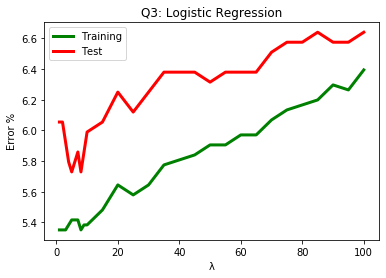

In [24]:
plt.plot(λList,trainingError,'g',label='Training', linewidth=3)
plt.plot(λList,testError,'r',label='Test', linewidth=3)
plt.title('Q3: Logistic Regression')
plt.ylabel('Error %')
plt.xlabel('λ')
plt.legend()
plt.show()

### What do you observe about the training and test errors as λ change?

The training and test error generally increase with increasing λ. However, the error is minimum for λ=4 and λ=7, which means these values of λ are better for this Logistic Regression model.

### Training and testing error rates for λ = 1, 10 and 100.

In [25]:
for λ in [1,10,100]:
    print ("λ: ",λ)
    print ("Training error:\t %.2f" % trainingError[λList.tolist().index(λ)])
    print ("Test error:\t %.2f" % testError[λList.tolist().index(λ)])
    print ("---------------------------")

λ:  1
Training error:	 5.35
Test error:	 6.05
---------------------------
λ:  10
Training error:	 5.38
Test error:	 5.99
---------------------------
λ:  100
Training error:	 6.39
Test error:	 6.64
---------------------------


=======================================================================================================================
## Q4: K-Nearest Neighbors ##

For the **log-transformed data**, implement a **KNN classifier** (see week 5 lecture notes on “Nonparametric Classification”). Use the Euclidean distance to measure distance between neighbors.

For each value of **K = {1, 2, · · · , 9, 10, 15, 20, · · · , 95, 100}** (note the jump in interval from 10 to 15 and beyond), compute the training and test error rates (i.e., percentage of emails classified wrongly). 

Make sure you include at least the following in your report:

**• Plots of training and test error rates versus K**

**• What do you observe about the training and test errors as K change?**

**• Training and testing error rates for K = 1, 10 and 100.**

=======================================================================================================================

### Functions to measure Euclidean Distance between a test sample and each training sample. 

### I tried several methods to get euclidean distance, but most methods are slow. The fastest among all is to use norm method from Numpy library.


In [26]:
def euclideanDistance(testRow,train):
    eucDist = []
    for trainRow in train:
        eucDist.append(dist.euclidean(testRow, trainRow))
    return eucDist

def FastEuclideanDistance(testRow, train):
    eucDist = []
    for trainRow in train:
        Dist = [(a - b)**2 for a, b in zip(testRow, trainRow)]
        eucDist.append(math.sqrt(sum(Dist)))
    return eucDist

def FasterEuclideanDistance(testRow,train):
    eucDist = []
    for trainRow in train:
        eucDist.append(np.linalg.norm(testRow-trainRow))
    return eucDist

### KNN Classifier.

### It returns the percentage of wrongly classified email data.

In [27]:
def KNN(k,xTest,yTest,xTrain,yTrain):
    result = []
    for xTestRow in xTest:
        eucDist = FasterEuclideanDistance(xTestRow,xTrain)
        kNearest = np.argsort(eucDist)[:k]
        probSpam = np.sum(yTrain[kNearest] == 1)
        probNonSpam = np.sum(yTrain[kNearest] == 0)
        result.append((probSpam > probNonSpam) + 0)
    return ( np.sum(yTest != result) / len(yTest)*100 )

### List of Ks mentioned in the assignment question

### K = {1, 2, · · · , 9, 10, 15, 20, · · · , 95, 100}

In [28]:
KList = np.hstack((np.arange(1,10,1), np.arange(10,105,5)))

## Run KNN classifier for training and test samples and compute the error rates.

In [29]:
trainError = []
testError = []
for k in KList:
    trainError.append(KNN(k,xTrainLog,yTrainFlat,xTrainLog,yTrainFlat))
    testError.append(KNN(k,xTestLog,yTestFlat,xTrainLog,yTrainFlat))

### Plots of training and test error rates versus K

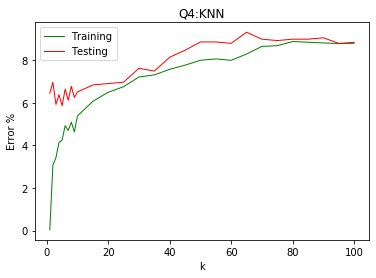

In [30]:
plt.plot(KList,trainError,'g',label='Training', linewidth=1)
plt.plot(KList,testError,'r',label='Testing', linewidth=1)
plt.title('Q4:KNN')
plt.ylabel('Error %')
plt.xlabel('k')
plt.legend()
plt.show()

### What do you observe about the training and test errors as K change?

It is clear from above graph that training error is minimum at K = 0. For 0 < K ≤ 30, training error increases drastically as K increases. For K ≥ 30, the training error increases slowly as K increases.

The test error rate doesn't change rapidly with increase in K. In other words, test error rate is more stable compared to training error rate. 

The training and test error rates are almost equal at very large K (K ≥ 60). Overall, K = 0 has the best result for training but test error is still as high as 6.5% for K = 0.

### Training and testing error rates for K = 1, 10 and 100.

In [31]:
for k in [1,10,100]:
    print ("K: ",k)
    print ("Training error:\t %.2f" % trainError[KList.tolist().index(k)])
    print ("Test error:\t %.2f" % testError[KList.tolist().index(k)])
    print ("---------------------------")

K:  1
Training error:	 0.03
Test error:	 6.45
---------------------------
K:  10
Training error:	 5.38
Test error:	 6.51
---------------------------
K:  100
Training error:	 8.84
Test error:	 8.79
---------------------------


========================================================================================================================
## Q5: Survey 

Please give an estimate of how much time you spent on this assignment.

========================================================================================================================

|**Question**   | **Time Spent**|
| ------------: | --------------: |
| Q1  | 10 hrs |
| Q2  | 8 hrs  |
| Q3  | 10 hrs |
| Q4  | 7 hrs |
| Report  | 3 hrs |
| **Total** |**38 hrs**|
